# Exploratory data analysis (EDA)
_https://arxiv.org/html/2510.22916v1_

## First walk_throught

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


### Check given data

In [6]:
# check file available
MAIN_DIR = Path("csiro-biomass/")
for el in MAIN_DIR.glob("*"):
    print(el)

csiro-biomass/test
csiro-biomass/test.csv
csiro-biomass/train
csiro-biomass/train.csv
csiro-biomass/sample_submission.csv


In [7]:
# Get data
trainset = pd.read_csv(MAIN_DIR / "train.csv")
testset = pd.read_csv(MAIN_DIR / "test.csv")
submission_test = pd.read_csv(MAIN_DIR / "sample_submission.csv")

In [8]:
trainset.head()

sample_id              image_path Sampling_Date State  \
0  ID1011485656__Dry_Clover_g  train/ID1011485656.jpg      2015/9/4   Tas   
1    ID1011485656__Dry_Dead_g  train/ID1011485656.jpg      2015/9/4   Tas   
2   ID1011485656__Dry_Green_g  train/ID1011485656.jpg      2015/9/4   Tas   
3   ID1011485656__Dry_Total_g  train/ID1011485656.jpg      2015/9/4   Tas   
4         ID1011485656__GDM_g  train/ID1011485656.jpg      2015/9/4   Tas   

           Species  Pre_GSHH_NDVI  Height_Ave_cm   target_name   target  
0  Ryegrass_Clover           0.62         4.6667  Dry_Clover_g   0.0000  
1  Ryegrass_Clover           0.62         4.6667    Dry_Dead_g  31.9984  
2  Ryegrass_Clover           0.62         4.6667   Dry_Green_g  16.2751  
3  Ryegrass_Clover           0.62         4.6667   Dry_Total_g  48.2735  
4  Ryegrass_Clover           0.62         4.6667         GDM_g  16.2750

### Check missing values

In [9]:
trainset.isna().sum().sum() # 0

np.int64(0)

### Check tabular data

In [10]:
# Extract tabular data
date = trainset["Sampling_Date"]
state = trainset["State"]
species = trainset["Species"]
ndvi = trainset["Pre_GSHH_NDVI"]
av_height = trainset["Height_Ave_cm"]

In [11]:
# Analyse tabular data
date.dtype # Object
date.nunique() # 28 => change type ? is date usefull ? maybe cut by month ?
year = date.apply(lambda row: int(row.split("/")[0]))
month = date.apply(lambda row: int(row.split("/")[1]))
month.dtype # int64
month.nunique() # 10

state.dtype # Object
state.nunique() # 4 ['Tas', 'NSW', 'WA', 'Vic'] => one hot encoding
species.nunique() # 15 => one hot encoding 
ndvi.dtype # float64 (it seem between 0 & 1)
av_height.dtype; # float64 => To scale

### Check image sample & dimension

Largeur : 2000
Hauteur : 1000


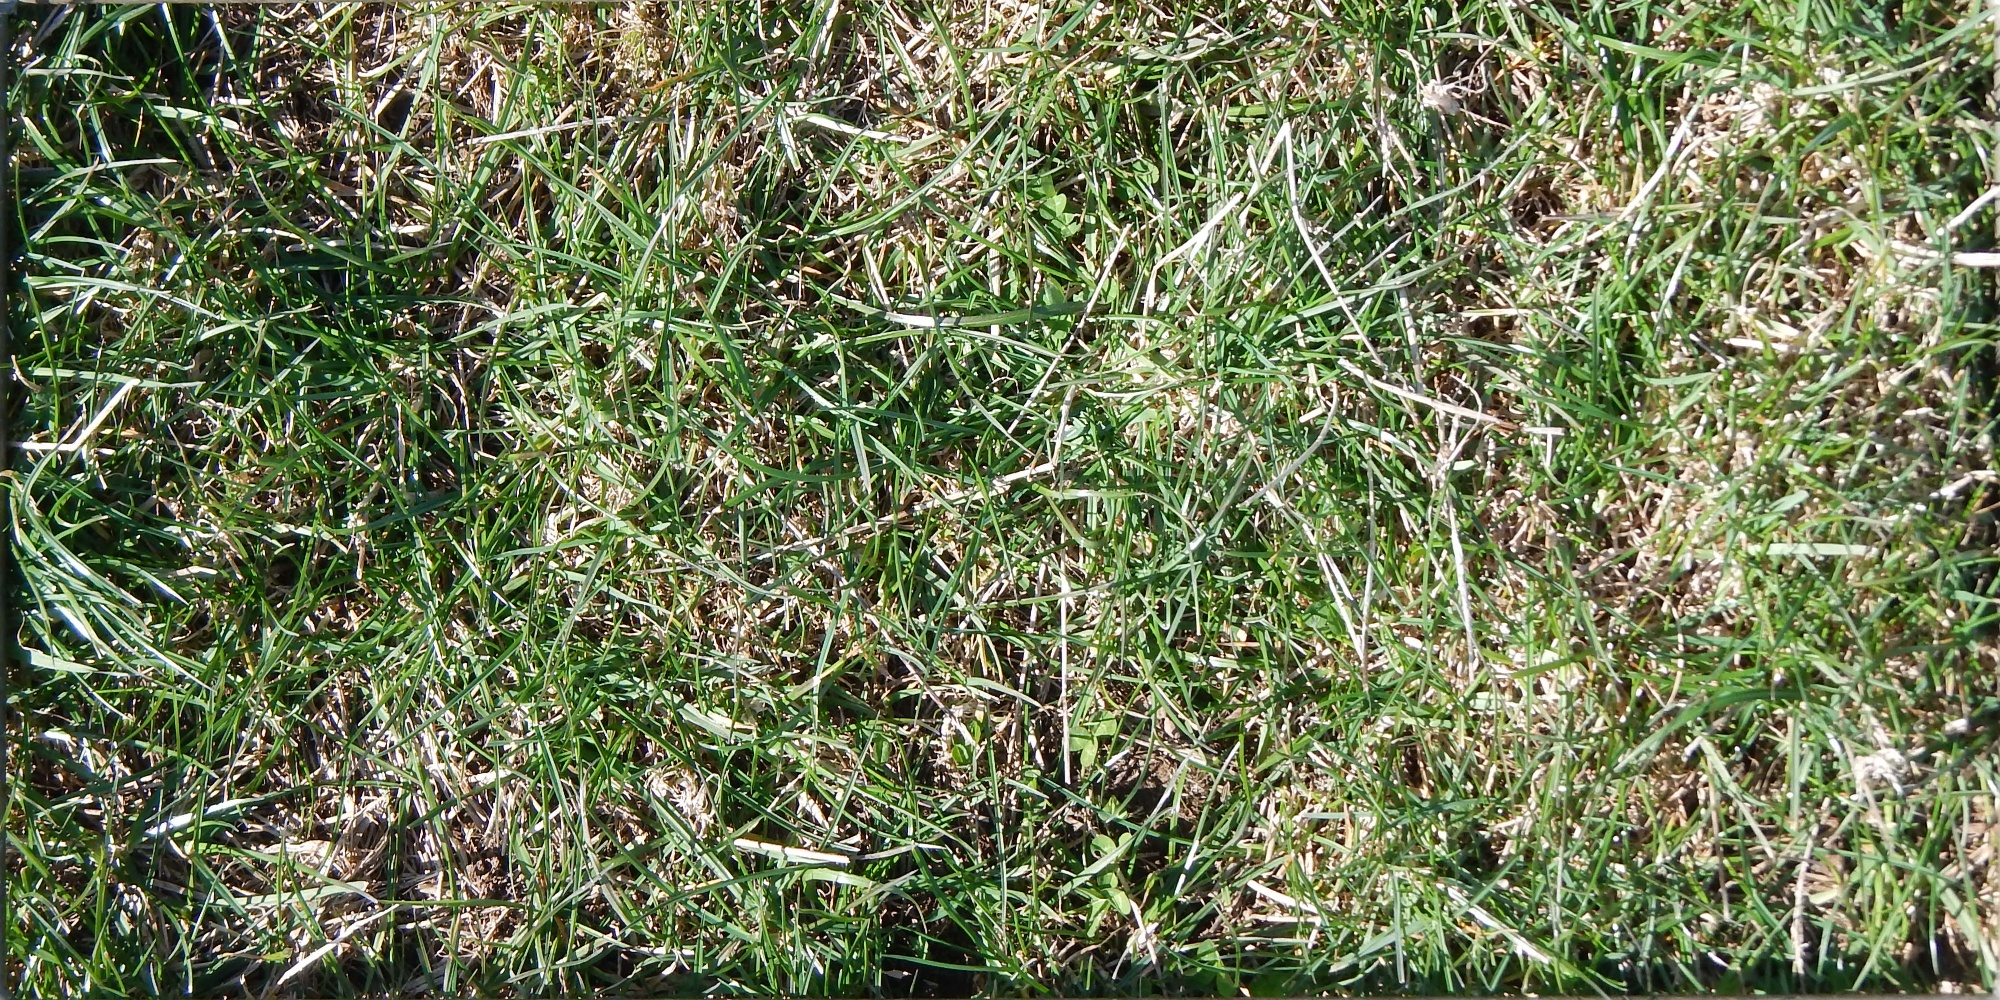

In [15]:
# Image sample
from PIL import Image

im = Image.open(MAIN_DIR / "train/ID1011485656.jpg")
largeur, hauteur = im.size
print("Largeur :", largeur)
print("Hauteur :", hauteur)
im

### Check target constraint & distribution

In [13]:
trainset.target.max(), trainset.target.min()

(np.float64(185.7), np.float64(0.0))

In [16]:
target = trainset.target.to_numpy().reshape((-1, 5))
target_df = pd.DataFrame(target, columns=["Dry_Clover_g", "Dry_Dead_g", "Dry_Green_g", "Dry_Total_g", "GDM_g"])

def get_each_target(target):
    """return: clover, dead, green, total, dmg"""
    return target[:, 0], target[:, 1], target[:, 2], target[:, 3], target[:, 4]

# take actual value
clover, dead, green, total, dmg = get_each_target(target)

In [17]:
# Math constaint
np.isclose(dmg, green + clover, rtol=1e-4).all(), np.isclose(total, green + clover + dead, rtol=1e-4).all()

(np.True_, np.False_)

In [18]:
mask = ~np.isclose(total, green + clover + dead, rtol=1e-4)
arg = np.argwhere(mask) # 1 element
total[arg], (green + clover + dead)[arg] # 10.19 vs 10.50

(array([[10.1912]]), array([[10.5]]))

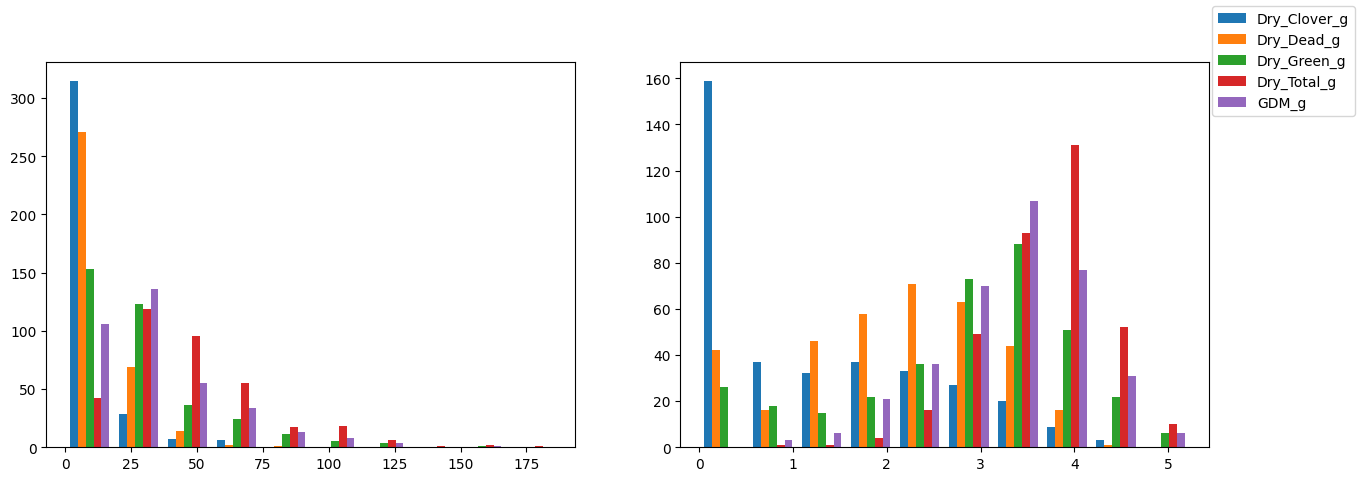

In [19]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# distribution of target:
y = np.ceil(target)
ax1.hist(y);

# justify log transform
y_log = np.log1p(target)
ax2.hist(y_log, label=target_df.columns);

fig.legend();

# Observation : right-skewed distributions ==> apply log to the target
# To stabilize variance and improve model evaluation robustness, 
# particularly for variables with high dynamic range or right-skewed distributions, 
# a log-stabilizing transformation is applied to all target variables before computing R2 values:

### Some math analyse

array([0.39, 0.21, 0.09, 0.31])

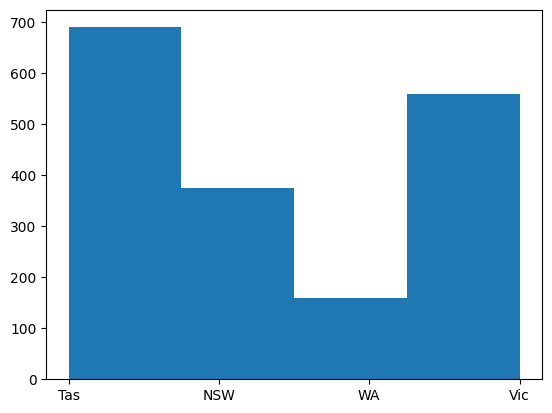

In [20]:
values, *_ = plt.hist(state, bins=state.nunique())
percent = values/values.sum()
np.round(percent,2)
# tas: 39% 
# nsw: 21%
# wa: 9%
# vic: 31%

array([0.27, 0.06, 0.01, 0.17, 0.12, 0.01, 0.11, 0.03, 0.02, 0.02, 0.03,
       0.08, 0.03, 0.02, 0.01])

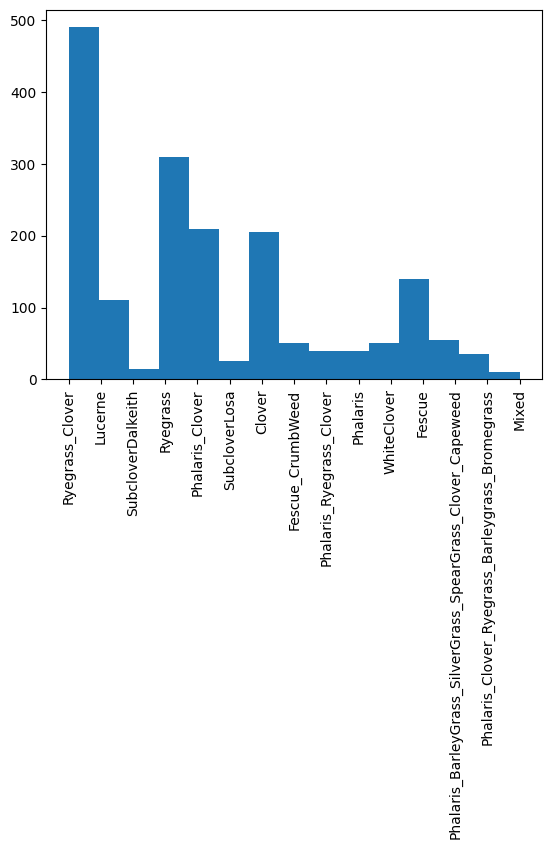

In [21]:
values, *_ = plt.hist(species, bins=species.nunique())
plt.xticks(rotation='vertical');

percent = values/values.sum()
np.round(percent,2) # Mainly "ryegrass_clover" at 27% then "Ryegrass" at 17% etc

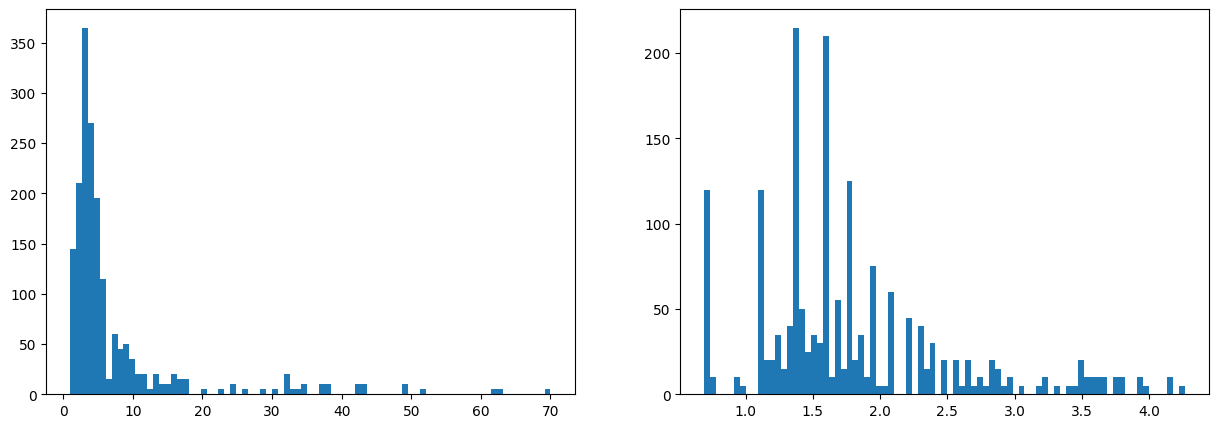

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# distribution of target:
ax1.hist(av_height, bins=av_height.nunique());

# justify log transform
av_height_log = np.log1p(av_height)
ax2.hist(av_height_log, bins=av_height.nunique());

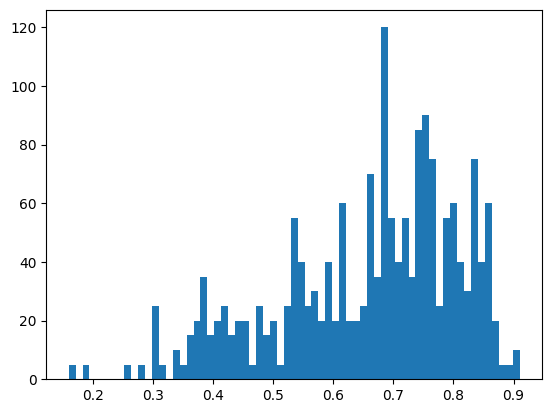

In [23]:
plt.hist(ndvi, bins=ndvi.nunique());

sep   apr   may   jul   jun   jan  nov   feb  aug   oct
%  0.19  0.03  0.12  0.11  0.15  0.05  0.1  0.07  0.1  0.08

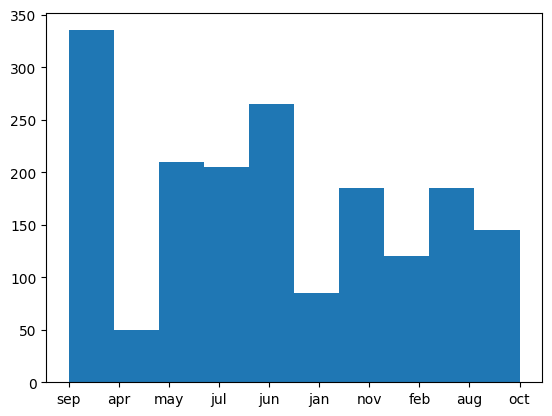

In [24]:
month_dic = {1:"jan", 2:"feb", 4:"apr", 5:"may", 6:"jun", 7:"jul", 8:"aug", 9:"sep", 10:"oct", 11:"nov"}
month_str = month.apply(lambda row: month_dic[row])
values, *_ = plt.hist(month_str, bins=month_str.nunique());
percent = values/values.sum()
pd.DataFrame({"%":np.round(percent,2)}, index=month_str.unique()).T

In [25]:
year.unique() # all date are within 2015

array([2015])

## Conclusion

- Dataset Structure: <br> Training set: 357 images with 5 target biomass components each (1,785 rows total)
<br>All images normalized to `2000 x 1000` pixels (70cm × 30cm quadrat, ~28.5 px/cm)
<br>Test set: ~800+ images (hidden during competition), only image paths available

- Available Features: <br>Training only: tabular data `[date, state, species, ndvi, Average height]`

- Train & Test: Images only

- Leverage Target Relationships -> *The targets have mathematical constraints*:

>`GDM_g = Dry_Green_g + Dry_Clover_g`
<br>
`Dry_Total_g = Dry_Green_g + Dry_Dead_g + Dry_Clover_g`
<br>
**Predict 3 base components → derive the other 2**


### Suggested Approaches (Ideas Only)
Given the constraint that only images are available at test time, here are viable strategies:
1. Pure Vision Model (Baseline): <br>CNN/ViT trained directly on images → 5 regression outputs
Architectures: EfficientNet, ConvNeXt, Swin Transformer
Multi-task learning with shared backbone

2. Knowledge Distillation from Tabular Data: <br> *Since tabular features are strong predictors during training:* <br>Train a "teacher" model using image + tabular features
Distill knowledge to a "student" model that uses only images
The student learns to implicitly predict NDVI/height from visual cues

3. Auxiliary Task Learning: <br>Train CNN to predict NDVI and height as auxiliary outputs
These intermediate predictions inform the final biomass prediction
Forces the network to learn vegetation density/structure features



## Tabular model (training only): "Teacher" model
**(not available for final inference)**


In [26]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn import __version__
__version__

'1.8.0'

In [27]:
target = trainset.target.to_numpy()
target = target.reshape((-1, 5)) 
target.shape, target[0:2]

((357, 5),
 array([[ 0.    , 31.9984, 16.2751, 48.2735, 16.275 ],
        [ 0.    ,  0.    ,  7.6   ,  7.6   ,  7.6   ]]))

In [28]:
def gen_features_df(initial_df):
    df = initial_df.drop(["target", "target_name", "sample_id", "image_path"], axis=1)
    df = df[0:-1:5].reset_index(drop=True)
    df.Height_Ave_cm = np.log1p(df.Height_Ave_cm)
    
    df.Sampling_Date = pd.to_datetime(initial_df.Sampling_Date)
    df.rename(columns={"Sampling_Date":"Date", "Pre_GSHH_NDVI":"NDVI"}, inplace=True)
    return df

train_df = gen_features_df(trainset)
train_df.head()

Date State            Species  NDVI  Height_Ave_cm
0 2015-09-04   Tas    Ryegrass_Clover  0.62       1.734607
1 2015-09-04   NSW            Lucerne  0.55       2.833213
2 2015-09-04    WA  SubcloverDalkeith  0.38       0.693147
3 2015-09-04   Tas           Ryegrass  0.66       1.791759
4 2015-09-04   Tas           Ryegrass  0.54       1.504077

In [29]:
X_train, X_test, y_train, y_test = train_test_split(train_df, target, test_size=0.2, random_state=42)
y_train_log = np.log1p(y_train) # np.log1p(x) = log(1 + y)
y_test_log = np.log1p(y_test)

In [30]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

categorical_features = ["State", "Species"]
numerical_features = ["NDVI", "Height_Ave_cm"]

####################################
categorical_transformer = OneHotEncoder(
    handle_unknown="ignore",  
    sparse_output=False # False to get a dense array 
)

####################################
scaler = StandardScaler()

####################################
def cyclical_day_encoder(X):
    day = pd.to_datetime(X.iloc[:, 0]).dt.dayofyear
    sin = np.sin(2 * np.pi * day / 365)
    cos = np.cos(2 * np.pi * day / 365)
    return np.c_[sin, cos]

date_transformer = FunctionTransformer(
    cyclical_day_encoder,
    validate=False,
    feature_names_out=lambda self, input_features: [ 
        f"{input_features[0]}_sin",
        f"{input_features[0]}_cos",
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features),
        ("num", scaler, numerical_features),
        ("date", date_transformer, ["Date"]),
    ]
)

In [31]:
X_encoded = preprocessor.fit_transform(X_train)
X_encoded_df = pd.DataFrame(X_encoded, columns=preprocessor.get_feature_names_out())
X_encoded_df.head()

cat__State_NSW  cat__State_Tas  cat__State_Vic  cat__State_WA  \
0             0.0             0.0             1.0            0.0   
1             0.0             0.0             0.0            1.0   
2             0.0             0.0             1.0            0.0   
3             0.0             0.0             1.0            0.0   
4             0.0             0.0             1.0            0.0   

   cat__Species_Clover  cat__Species_Fescue  cat__Species_Fescue_CrumbWeed  \
0                  0.0                  0.0                            0.0   
1                  1.0                  0.0                            0.0   
2                  0.0                  0.0                            0.0   
3                  0.0                  0.0                            0.0   
4                  0.0                  0.0                            0.0   

   cat__Species_Lucerne  cat__Species_Mixed  cat__Species_Phalaris  ...  \
0                   0.0                 0.0                    0.0  ...   
1                   0.0                 0.0                    0.0  ...   
2                   0.0                 0.0                    0.0  ...   
3                   0.0                 0.0                    0.0  ...   
4                   0.0                 0.0                    0.0  ...   

   cat__Species_Phalaris_Ryegrass_Clover  cat__Species_Ryegrass  \
0                                    0.0                    0.0   
1                                    0.0                    0.0   
2                                    0.0                    0.0   
3                                    0.0                    0.0   
4                                    0.0                    0.0   

   cat__Species_Ryegrass_Clover  cat__Species_SubcloverDalkeith  \
0                           0.0                             0.0   
1                           0.0                             0.0   
2                           0.0                             0.0   
3                           0.0                             0.0   
4                           0.0                             0.0   

   cat__Species_SubcloverLosa  cat__Species_WhiteClover  num__NDVI  \
0                         0.0                       0.0   0.747845   
1                         0.0                       0.0  -0.432963   
2                         0.0                       0.0   0.288642   
3                         0.0                       0.0  -1.088968   
4                         0.0                       0.0   0.682245   

   num__Height_Ave_cm  date__Date_sin  date__Date_cos  
0            0.215806        0.008607       -0.999963  
1           -1.502833        0.255353        0.966848  
2           -0.551919       -0.008607       -0.999963  
3           -0.452704       -0.895839       -0.444378  
4           -0.245793        0.094537       -0.995521  

[5 rows x 23 columns]

In [32]:
model_tab = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("regressor", RandomForestRegressor(
        n_estimators=300,
        random_state=42,
        max_depth=5,
        min_samples_leaf=2,
        n_jobs=-1,
        )
    )
])

In [33]:
model_tab.fit(X_train, y_train_log)

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['State', 'Species']),
                                                 ('num', StandardScaler(),
                                                  ['NDVI', 'Height_Ave_cm']),
                                                 ('date',
                                                  FunctionTransformer(feature_names_out=<function <lambda> at 0x1164d7320>,
                                                                      func=<function cyclical_day_encoder at 0x1164d71c0>),
                                                  ['Date'])])),
                ('regressor',
                 RandomForestRegressor(max_depth=5, min_samples_leaf=2,
                                       n_estimators=300, n_jobs=-1,
                                       random_state=42))])

In [34]:
train_score = model_tab.score(X_train, y_train_log) # by default R2 score
test_score = model_tab.score(X_test, y_test_log)

print(f"Test Score: {test_score:.2f}")
print(f"\nOverfitting ?\nTrain score:, {train_score:.2f}") 

Test Score: 0.64

Overfitting ?
Train score:, 0.75


In [36]:
def diff_target_math_constraint(y_pred, return_mean=True):
    """return: dmg diff, total diff. Between 'calculated and predicted' values, round 4 digit"""
    clover, dead, green, total, dmg = get_each_target(y_pred)
    dmg_constraint = clover + green
    total_constraint = dmg_constraint + dead
    dmg_diff = np.abs((dmg_constraint - dmg).sum())
    total_diff = np.abs((total_constraint - total).sum())
    dmg_diff = dmg_diff/dmg.size if return_mean else dmg_diff
    dmg_diff = total_diff/total.size if return_mean else total_diff
    return np.round(dmg_diff, 4), np.round(total_diff, 4)

y_pred_log = model_tab.predict(X_test)
diff_target_math_constraint(np.expm1(y_pred_log)) # is the model learning the math constraint ? => want close to 0

(np.float64(5.4857), np.float64(394.9684))

## CSIRO globally weighted coefficient of determination : $R^2_w$
Each row is weighted according to its target type using the following weights:
- Dry_Clover_g: 0.1
- Dry_Dead_g: 0.1
- Dry_Green_g: 0.1
- GDM_g: 0.2
- Dry_Total_g: 0.5

$$R^2_w = 1 - \frac{\sum_j w_j (y_j - \hat{y}_j)^2}{\sum_j w_j (y_j - \bar{y}_w)^2}$$
Where : $$\bar{y}_w = \frac{\sum_j w_j y_j}{\sum_j w_j}$$

- $y_j$: ground-truth value for data point 
- $\hat{y}_j$: model prediction for data point 
- :$w_j$ per-row weight based on target type
- $\bar{y}_w$: global weighted mean of all ground-truth values

In [37]:
def get_each_target(target):
    """return: clover, dead, green, total, dmg"""
    return target[:, 0], target[:, 1], target[:, 2], target[:, 3], target[:, 4]


def get_weights():
    """Each row is weighted accordily"""
    return {"clover":0.1, "dead":0.1, "green":0.1,"total":0.5, "dmg":0.2}

def Yw(y_true):
    """global weighted mean of all ground-truth values"""
    each_target_size = y_true.shape[0] # output for each prediction
    weights = get_weights()
    N = sum(w*targ for w, targ in zip(weights.values(), get_each_target(y_true)))
    D = sum(weights.values()) * each_target_size
    return (N/D).sum()

def SSres(y_true, y_pred):
    """Measures the total error of the model’s predictions"""
    weights = get_weights()
    SS = sum(w*np.square(targ_true - targ_pred) 
             for w, targ_true, targ_pred 
             in zip(weights.values(), get_each_target(y_true), get_each_target(y_pred))
            )
    return SS.sum()

def SStot(y_true):
    """Measures the total weighted variance in the data"""
    y_w = Yw(y_true)
    weights = get_weights()
    SS = sum(w*np.square(targ_true - y_w) 
             for w, targ_true 
             in zip(weights.values(), get_each_target(y_true))
            )
    return SS.sum()

def r2_csiro(y_true, y_pred):
    """Globally weighted coefficient of determination"""
    SS_res = SSres(y_true, y_pred)
    SS_tot = SStot(y_true)
    return 1 - SS_res / SS_tot
 

In [38]:
y_pred_log = model_tab.predict(X_test)

r2_test = r2_csiro(y_test_log, y_pred_log)
r2_train = r2_csiro(y_train_log, model_tab.predict(X_train))

print(f"Test Score: {r2_test:.3f}")
print(f"\nOverfitting ?\nTrain score:, {r2_train:.3f}")  # gap between train & test 

Test Score: 0.803

Overfitting ?
Train score:, 0.870


### Features importances

In [39]:
import pandas as pd
import numpy as np

rf = model_tab.named_steps["regressor"] # RandomForestRegressor
feature_names = model_tab.named_steps["preprocessing"].get_feature_names_out()
importances = rf.feature_importances_
feat_imp = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values("importance", ascending=False)

def aggregate_features_importance_df(features_importance):
    features_importance["group"] = features_importance["feature"].str.replace(r"^cat__|^num__", "", regex=True)
    features_importance["group"] = features_importance["group"].str.split("_").str[0]
    
    grouped_imp = (
        features_importance
        .groupby("group", as_index=False)["importance"]
        .sum()
        .sort_values("importance", ascending=False)
    )
    return grouped_imp

aggregate_features_importance_df(feat_imp)

group  importance
0   Height    0.416253
3    State    0.216819
2  Species    0.200607
1     NDVI    0.137412
4     date    0.028908

In [40]:
from sklearn.inspection import permutation_importance

X_enc = model_tab.named_steps["preprocessing"].transform(X_train)

r = permutation_importance(
    model_tab.named_steps["regressor"],
    X_enc,
    y_train_log,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

perm_imp = pd.DataFrame({
    "feature": model_tab.named_steps["preprocessing"].get_feature_names_out(),
    "importance": r.importances_mean
}).sort_values("importance", ascending=False)

In [41]:
agg_feat_importance = aggregate_features_importance_df(perm_imp)
agg_feat_importance

group  importance
0   Height    0.627696
1     NDVI    0.194345
3    State    0.193707
2  Species    0.191984
4     date    0.016564

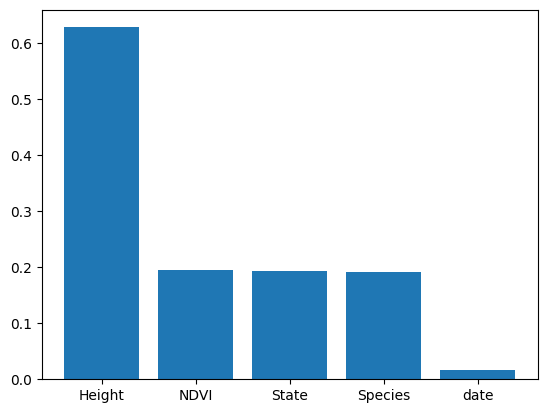

In [42]:
plt.bar(agg_feat_importance.group, agg_feat_importance.importance);

# CNN Model

In [43]:
import torch
from torch.utils.data import Dataset
from PIL import Image
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device, torch.__version__

(device(type='cpu'), '2.9.1')

In [57]:
class ImageTabularRegressionDataset(Dataset):
    def __init__(self, image_df, X_tab, targets, transform=None):
        self.image_df = image_df.reset_index(drop=True)
        self.X_tab = torch.tensor(X_tab, dtype=torch.float32)
        self.targets = torch.tensor(targets, dtype=torch.float32)
        self.transform = transform

    def __len__(self):
        return len(self.image_df)

    def __getitem__(self, idx):
        # image
        img_path = self.image_df.loc[idx, "image_path"]
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        # tabulaire
        tab = self.X_tab[idx]

        # target
        target = self.targets[idx]

        return image, tab, target


In [58]:
from torchvision import transforms

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # Ce sont les statistiques (moyenne / écart-type) calculées sur ImageNet, 
        std=[0.229, 0.224, 0.225], # le dataset sur lequel EfficientNet a été pré-entraîné.
    )
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    )
])

In [59]:
def gen_data_for_DL(initial_df):
    tab_df = gen_features_df(initial_df)
    scaler = StandardScaler()
    encoder = LabelEncoder()
    tab_processes = scaler.fit_transform(tab_df[["NDVI", "Height_Ave_cm"]])
    tab_df_processes = pd.DataFrame(tab_processes, columns=scaler.get_feature_names_out())
    tab_df_processes["Species"] = encoder.fit_transform(tab_df.Species)

    image_df = initial_df[["image_path"]].loc[0::5].reset_index(drop=True)
    image_df = image_df.apply(lambda row: (MAIN_DIR / row))

    targets = initial_df.target.to_numpy()
    targets = targets.reshape((-1, 5)) 
    targets = np.log1p(targets)

    return image_df, tab_df_processes, targets, [scaler, encoder]

image_df, tab_df_processes, targets, preprocessing = gen_data_for_DL(trainset)

In [60]:
preprocessing[1].inverse_transform(tab_df_processes.Species)[:2], preprocessing[1].classes_.size

(array(['Ryegrass_Clover', 'Lucerne'], dtype=object), 15)

In [61]:
image_train, image_test, tab_train, tab_test, y_train, y_test = train_test_split(image_df, tab_df_processes, targets, test_size=0.2)

In [ ]:
from torch.utils.data import DataLoader

def get_dataloader(image, tabular, y_label, training=True):
    if isinstance(tabular, pd.DataFrame):
        tabular = tabular.to_numpy()
    dataset = ImageTabularRegressionDataset(
        image,
        tabular,
        y_label,
        transform=train_transform
    )
    
    loader = DataLoader(
        dataset=dataset,
        batch_size=32,
        shuffle=training,
        num_workers=4, 
        # pin_memory=True
    )
    return loader

train_loader = get_dataloader(image_train, tab_train, y_train)
test_loader = get_dataloader(image_test, tab_test, y_test, training=False)

In [ ]:
for im, tab, y in train_loader:
    break

RuntimeError: Caught RuntimeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/Users/dorian/Documents/CODE/datascience/kaggle/CSIRO - Image2Biomass Prediction/.venv/lib/python3.14/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/Users/dorian/Documents/CODE/datascience/kaggle/CSIRO - Image2Biomass Prediction/.venv/lib/python3.14/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
           ~~~~~~~~~~~~~~~^^^^^^
  File "/Users/dorian/Documents/CODE/datascience/kaggle/CSIRO - Image2Biomass Prediction/.venv/lib/python3.14/site-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/Users/dorian/Documents/CODE/datascience/kaggle/CSIRO - Image2Biomass Prediction/.venv/lib/python3.14/site-packages/torch/utils/data/_utils/collate.py", line 212, in collate
    collate(samples, collate_fn_map=collate_fn_map)
    ~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dorian/Documents/CODE/datascience/kaggle/CSIRO - Image2Biomass Prediction/.venv/lib/python3.14/site-packages/torch/utils/data/_utils/collate.py", line 155, in collate
    return collate_fn_map[elem_type](batch, collate_fn_map=collate_fn_map)
           ~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/dorian/Documents/CODE/datascience/kaggle/CSIRO - Image2Biomass Prediction/.venv/lib/python3.14/site-packages/torch/utils/data/_utils/collate.py", line 270, in collate_tensor_fn
    storage = elem._typed_storage()._new_shared(numel, device=elem.device)
  File "/Users/dorian/Documents/CODE/datascience/kaggle/CSIRO - Image2Biomass Prediction/.venv/lib/python3.14/site-packages/torch/storage.py", line 1203, in _new_shared
    untyped_storage = torch.UntypedStorage._new_shared(
        size * self._element_size(), device=device
    )
  File "/Users/dorian/Documents/CODE/datascience/kaggle/CSIRO - Image2Biomass Prediction/.venv/lib/python3.14/site-packages/torch/storage.py", line 414, in _new_shared
    return cls._new_using_filename_cpu(size)
           ~~~~~~~~~~~~~~~~~~~~~~~~~~~^^^^^^
RuntimeError: Broken pipe


: 

In [63]:
import torch
import torch.nn as nn
import timm

class MultiTaskBiomassModel(nn.Module):
    def __init__(self, num_species=15):
        super().__init__()
        
        # Shared backbone
        self.backbone = timm.create_model('efficientnet_b0', pretrained=True, num_classes=0)
        feature_dim = self.backbone.num_features  # 1280 for efficientnet_b0
        
        # Auxiliary heads (predict privileged features)
        self.height_head = nn.Linear(feature_dim, 1)      # Regression
        self.ndvi_head = nn.Linear(feature_dim, 1)        # Regression
        self.species_head = nn.Linear(feature_dim, num_species)  # Classification. No softmax, include in CrossEntropyLoss
        
        # Main task head (predict biomass)
        self.biomass_head = nn.Sequential(
            nn.Linear(feature_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 5)  # 5 biomass targets
        )
    
    def forward(self, x):
        features = self.backbone(x)
        
        return {
            'biomass': self.biomass_head(features),
            'height': self.height_head(features),
            'ndvi': self.ndvi_head(features),
            'species': self.species_head(features)
        }


class MultiTaskLoss(nn.Module):
    def __init__(self, aux_weight=0.3):
        super().__init__()
        self.aux_weight = aux_weight
        self.mse = nn.MSELoss()
        self.ce = nn.CrossEntropyLoss()

    def _get_tabular_target(self, tab, name):
        if name == "ndvi":
            return tab[:, 0].reshape((-1, 1))
        elif name == "height":
            return tab[:, 1].reshape((-1, 1))
        elif name == "species":
            return tab[:, 2].long()
        
    
    def forward(self, predictions, tab, targets):
        # Main loss (biomass) - most important
        loss_biomass = self.mse(predictions['biomass'], targets)
        
        # Auxiliary losses (privileged features)
        loss_height = self.mse(predictions['height'], self._get_tabular_target(tab, "height"))
        loss_ndvi = self.mse(predictions['ndvi'], self._get_tabular_target(tab, "ndvi"))
        loss_species = self.ce(predictions['species'], self._get_tabular_target(tab, "species"))
        
        # Combine
        aux_loss = loss_height + loss_ndvi + loss_species
        total_loss = loss_biomass + self.aux_weight * aux_loss
        
        return total_loss, {
            'biomass': loss_biomass.item(),
            'height': loss_height.item(),
            'ndvi': loss_ndvi.item(),
            'species': loss_species.item()
        }


In [73]:
from time import perf_counter
from tqdm.auto import tqdm

model = MultiTaskBiomassModel(num_species=preprocessing[1].classes_.size)
criterion = MultiTaskLoss()

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=1e-4,
    weight_decay=1e-4
)

def train_epoch(model, train_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.train()
    losses = []

    for images, tab, targets in train_loader:
        images = images.to(device)
        targets = targets.to(device)
        tab = tab.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, tab, targets)
        loss[0].backward()
        optimizer.step()
        losses.append(loss[0].item())

    print(f"Epoch {epoch}: loss={losses[-1]/len(train_loader):.4f}")

    return losses

epochs = 5
T = perf_counter()
for epoch in tqdm(range(epochs)):
    losses = train_epoch(model, train_loader)
print(f"Total time: {perf_counter() - T:.2f}")

  0%|          | 0/5 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
def evaluate(model, test_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    with torch.inference_mode():
        y_true = torch.Tensor().to(device)
        predictions = torch.Tensor().to(device)
        for im, _, label in tqdm(test_loader):
            im = im.to(device)
            label = label.to(device)
            pred = model(im)

            y_true = torch.cat((y_true, label), axis=0)
            predictions = torch.cat((predictions, pred["biomass"]), axis=0)
            
    return r2_csiro(y_true=y_true.cpu(), 
                 y_pred=predictions.cpu())
            
evaluate(model, test_loader)    

  0%|          | 0/3 [00:00<?, ?it/s]

/tmp/ipykernel_55/3234444202.py:21: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  SS = sum(w*np.square(targ_true - targ_pred)
/tmp/ipykernel_55/3234444202.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  SS = sum(w*np.square(targ_true - y_w)


tensor(0.6462)